In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
import torch
import tensorflow as tf
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

TensorFlow 2.x selected.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
path ="/content/drive/My Drive/19fallml/segmentedtensor"
sampleX = torch.load(path+'/sample_X.pt')
# raw_sampleX = torch.load(path+'/sample_train_X.pt').numpy()
# sampleX = np.squeeze(raw_sampleX)
sampleY = np.loadtxt(path+'/sample_Y.txt').astype(np.int64)
sampleY = torch.from_numpy(sampleY)

print(sampleX.size())
print(sampleY.size())

torch.Size([1623, 3, 224, 224])
torch.Size([1623])


In [0]:
dataset = torch.utils.data.TensorDataset(sampleX, sampleY)

data_size = int(0.25 * len(dataset))  #只取1/4的数据作为dataset
dataset, _ = torch.utils.data.random_split(dataset, [data_size, len(dataset)-data_size])

train_size = int(0.8 * len(dataset)) #80%training
test_size = len(dataset) - train_size #20%testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataset_sizes={
    "Train":train_size,
    "Test":test_size
}

class_names = ["Black grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

# 把 dataset 放入 DataLoader
Train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=4,               # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

Test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=4,               # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

dataloaders={
    "Train":Train_loader, #train dataset in train_loader
    "Test":Test_loader ##test dataset in test_loader
}



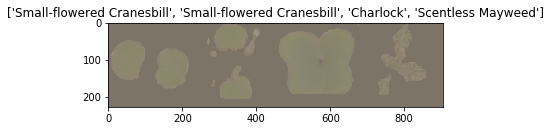

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(Train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
 # training model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(25):
        print('Epoch {}/{}'.format(epoch, 24))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
#Fine tuning
model_ft = models.densenet121(pretrained=True)   #densenet121
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 12)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs, learning rate 每7个epoch缩小为0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 93.9MB/s]


In [9]:
# Train and evaluate
model_ft= train_model(model_ft, criterion, optimizer_ft,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 2.0631 Acc: 0.3210
Test Loss: 1.2594 Acc: 0.6296

Epoch 1/24
----------
Train Loss: 1.0076 Acc: 0.6944
Test Loss: 1.0169 Acc: 0.6543

Epoch 2/24
----------
Train Loss: 0.8103 Acc: 0.7284
Test Loss: 0.5538 Acc: 0.8025

Epoch 3/24
----------
Train Loss: 0.3957 Acc: 0.8981
Test Loss: 0.5311 Acc: 0.8025

Epoch 4/24
----------
Train Loss: 0.3764 Acc: 0.9012
Test Loss: 0.4924 Acc: 0.8025

Epoch 5/24
----------
Train Loss: 0.2182 Acc: 0.9414
Test Loss: 0.3569 Acc: 0.8519

Epoch 6/24
----------
Train Loss: 0.2106 Acc: 0.9475
Test Loss: 0.3232 Acc: 0.8765

Epoch 7/24
----------
Train Loss: 0.1314 Acc: 0.9815
Test Loss: 0.3690 Acc: 0.8395

Epoch 8/24
----------
Train Loss: 0.1003 Acc: 0.9877
Test Loss: 0.2790 Acc: 0.8642

Epoch 9/24
----------
Train Loss: 0.1257 Acc: 0.9722
Test Loss: 0.3752 Acc: 0.8519

Epoch 10/24
----------
Train Loss: 0.1049 Acc: 0.9877
Test Loss: 0.3412 Acc: 0.8889

Epoch 11/24
----------
Train Loss: 0.0768 Acc: 0.9938
Test Loss: 0.2882 Acc